In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
pd.set_option("display.max_columns", 111)
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score

from category_encoders import OneHotEncoder

import tensorflow.keras as tfk

In [2]:
data = pd.read_excel('dataset.xlsx')
data['SARS-Cov-2 exam result'] = data['SARS-Cov-2 exam result'].map(dict(negative=0, positive=1))
data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in data.columns]
data['Urine___pH'] = data['Urine___pH'].map(lambda x: -100 if isinstance(x, str) else x).astype(float)
data['Urine___Leukocytes'] = data['Urine___Leukocytes'].map(lambda x: 500 if x == '<1000' else x).astype(float)






In [3]:
data.head()

,Patient_ID,Patient_age_quantile,SARS_Cov_2_exam_result,Patient_addmited_to_regular_ward__1_yes__0_no_,Patient_addmited_to_semi_intensive_unit__1_yes__0_no_,Patient_addmited_to_intensive_care_unit__1_yes__0_no_,Hematocrit,Hemoglobin,Platelets,Mean_platelet_volume_,Red_blood_Cells,Lymphocytes,Mean_corpuscular_hemoglobin_concentration__MCHC_,Leukocytes,Basophils,Mean_corpuscular_hemoglobin__MCH_,Eosinophils,Mean_corpuscular_volume__MCV_,Monocytes,Red_blood_cell_distribution_width__RDW_,Serum_Glucose,Respiratory_Syncytial_Virus,Influenza_A,Influenza_B,Parainfluenza_1,CoronavirusNL63,Rhinovirus_Enterovirus,Mycoplasma_pneumoniae,Coronavirus_HKU1,Parainfluenza_3,Chlamydophila_pneumoniae,Adenovirus,Parainfluenza_4,Coronavirus229E,CoronavirusOC43,Inf_A_H1N1_2009,Bordetella_pertussis,Metapneumovirus,Parainfluenza_2,Neutrophils,Urea,Proteina_C_reativa_mg_dL,Creatinine,Potassium,Sodium,Influenza_B__rapid_test,Influenza_A__rapid_test,Alanine_transaminase,Aspartate_transaminase,Gamma_glutamyltransferase_,Total_Bilirubin,Direct_Bilirubin,Indirect_Bilirubin,Alkaline_phosphatase,Ionized_calcium_,Strepto_A,Magnesium,pCO2__venous_blood_gas_analysis_,Hb_saturation__venous_blood_gas_analysis_,Base_excess__venous_blood_gas_analysis_,pO2__venous_blood_gas_analysis_,Fio2__venous_blood_gas_analysis_,Total_CO2__venous_blood_gas_analysis_,pH__venous_blood_gas_analysis_,HCO3__venous_blood_gas_analysis_,Rods__,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine___Esterase,Urine___Aspect,Urine___pH,Urine___Hemoglobin,Urine___Bile_pigments,Urine___Ketone_Bodies,Urine___Nitrite,Urine___Density,Urine___Urobilinogen,Urine___Protein,Urine___Sugar,Urine___Leukocytes,Urine___Crystals,Urine___Red_blood_cells,Urine___Hyaline_cylinders,Urine___Granular_cylinders,Urine___Yeasts,Urine___Color,Partial_thromboplastin_time__PTT__,Relationship__Patient_Normal_,International_normalized_ratio__INR_,Lactic_Dehydrogenase,Prothrombin_time__PT___Activity,Vitamin_B12,Creatine_phosphokinase__CPK__,Ferritin,Arterial_Lactic_Acid,Lipase_dosage,D_Dimer,Albumin,Hb_saturation__arterial_blood_gases_,pCO2__arterial_blood_gas_analysis_,Base_excess__arterial_blood_gas_analysis_,pH__arterial_blood_gas_analysis_,Total_CO2__arterial_blood_gas_analysis_,HCO3__arterial_blood_gas_analysis_,pO2__arterial_blood_gas_analysis_,Arteiral_Fio2,Phosphor,ctO2__arterial_blood_gas_analysis_
0,44477f75e8169d2,13,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f

In [4]:
X = data.iloc[:, 6:]
X['Patient_age_quantile'] = data['Patient_age_quantile']
X.head()

,Hematocrit,Hemoglobin,Platelets,Mean_platelet_volume_,Red_blood_Cells,Lymphocytes,Mean_corpuscular_hemoglobin_concentration__MCHC_,Leukocytes,Basophils,Mean_corpuscular_hemoglobin__MCH_,Eosinophils,Mean_corpuscular_volume__MCV_,Monocytes,Red_blood_cell_distribution_width__RDW_,Serum_Glucose,Respiratory_Syncytial_Virus,Influenza_A,Influenza_B,Parainfluenza_1,CoronavirusNL63,Rhinovirus_Enterovirus,Mycoplasma_pneumoniae,Coronavirus_HKU1,Parainfluenza_3,Chlamydophila_pneumoniae,Adenovirus,Parainfluenza_4,Coronavirus229E,CoronavirusOC43,Inf_A_H1N1_2009,Bordetella_pertussis,Metapneumovirus,Parainfluenza_2,Neutrophils,Urea,Proteina_C_reativa_mg_dL,Creatinine,Potassium,Sodium,Influenza_B__rapid_test,Influenza_A__rapid_test,Alanine_transaminase,Aspartate_transaminase,Gamma_glutamyltransferase_,Total_Bilirubin,Direct_Bilirubin,Indirect_Bilirubin,Alkaline_phosphatase,Ionized_calcium_,Strepto_A,Magnesium,pCO2__venous_blood_gas_analysis_,Hb_saturation__venous_blood_gas_analysis_,Base_excess__venous_blood_gas_analysis_,pO2__venous_blood_gas_analysis_,Fio2__venous_blood_gas_analysis_,Total_CO2__venous_blood_gas_analysis_,pH__venous_blood_gas_analysis_,HCO3__venous_blood_gas_analysis_,Rods__,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine___Esterase,Urine___Aspect,Urine___pH,Urine___Hemoglobin,Urine___Bile_pigments,Urine___Ketone_Bodies,Urine___Nitrite,Urine___Density,Urine___Urobilinogen,Urine___Protein,Urine___Sugar,Urine___Leukocytes,Urine___Crystals,Urine___Red_blood_cells,Urine___Hyaline_cylinders,Urine___Granular_cylinders,Urine___Yeasts,Urine___Color,Partial_thromboplastin_time__PTT__,Relationship__Patient_Normal_,International_normalized_ratio__INR_,Lactic_Dehydrogenase,Prothrombin_time__PT___Activity,Vitamin_B12,Creatine_phosphokinase__CPK__,Ferritin,Arterial_Lactic_Acid,Lipase_dosage,D_Dimer,Albumin,Hb_saturation__arterial_blood_gases_,pCO2__arterial_blood_gas_analysis_,Base_excess__arterial_blood_gas_analysis_,pH__arterial_blood_gas_analysis_,Total_CO2__arterial_blood_gas_analysis_,HCO3__arterial_blood_gas_analysis_,pO2__arterial_blood_gas_analysis_,Arteiral_Fio2,Phosphor,ctO2__arterial_blood_gas_analysis_,Patient_age_quantile
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
1,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

- simples fato de ser não-nulo possui informação, não é nulo at random
- em que momento deve ser feita a previsão? após exames? após detecção? na admissão?
- sintomas relatados como features

In [5]:
kf = KFold(2, shuffle=True, random_state=0)

In [6]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [8]:
from category_encoders import OrdinalEncoder

In [23]:
cats = X.select_dtypes(include=object).columns.tolist()

In [24]:
?OrdinalEncoder

Init signature: OrdinalEncoder(verbose=0, mapping=None, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value')
Docstring:     
Encodes categorical features as ordinal, in one ordered feature.

Ordinal encoding uses a single column of integers to represent the classes. An optional mapping dict can be passed
in; in this case, we use the knowledge that there is some true order to the classes themselves. Otherwise, the classes
are assumed to have no true order and integers are selected at random.

Parameters
----------

verbose: int
    integer indicating verbosity of the output. 0 for none.
cols: list
    a list of columns to encode, if None, all string columns will be encoded.
drop_invariant: bool
    boolean for whether or not to drop columns with 0 variance.
return_df: bool
    boolean for whether to return a pandas DataFrame from transform (otherwise it will be a numpy array).
mapping: list of dict
    a mapping of class to label to use for th

In [26]:
for tr, ts in kf.split(X):
    Xtr = X.iloc[tr]
    Xts = X.iloc[ts]
    ytr = data.iloc[tr]['SARS_Cov_2_exam_result']
    yts = data.iloc[ts]['SARS_Cov_2_exam_result']
    
    
    #Xtr.loc[:, cats] = Xtr.loc[:, cats].fillna("missing")
    
    enc = OrdinalEncoder(cols=cats)
    Xtr = enc.fit_transform(Xtr).fillna(-10)
    Xts = enc.transform(Xts).fillna(-10)
    

    
    mdl = RandomForestClassifier(random_state=200, class_weight='balanced', n_estimators=1000, 
                                 min_samples_leaf=8)
    mdl.fit(Xtr, ytr)
    
    p = mdl.predict_proba(Xts)[:,1]
    
    print("AUC= ", roc_auc_score(yts,p))
    
    #plot_tree(mdl)
    #break

AUC=  0.6293450423403499
AUC=  0.6506995083186273


In [27]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [28]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(Xtr)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


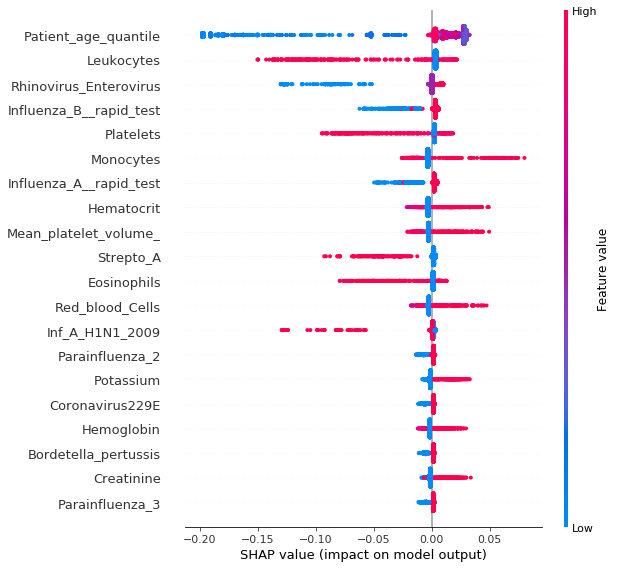

In [29]:
shap.summary_plot(shap_values[1], Xtr)

- engenharia reversa da decisão do médico de pedir exames...
- ainda pode ser útil:
    - o que leva um médico a pedir exame de sódio e potássio? o raciocínio pode ser usado para indicar covid 

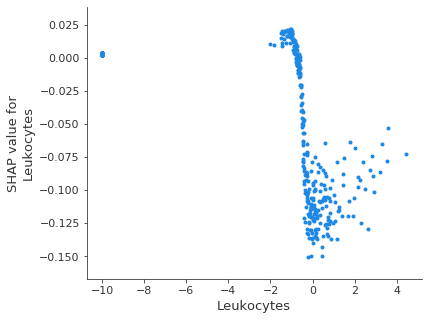

In [30]:
shap.dependence_plot('Leukocytes',shap_values[1], Xtr, interaction_index=None)

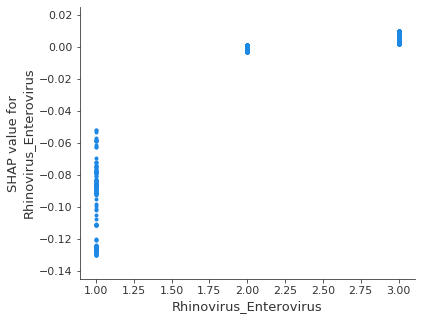

In [32]:
shap.dependence_plot('Rhinovirus_Enterovirus',shap_values[1], Xtr, interaction_index=None)

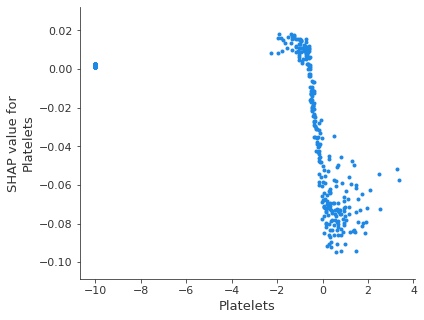

In [33]:
shap.dependence_plot('Platelets',shap_values[1], Xtr, interaction_index=None)